<a href="https://colab.research.google.com/github/ahtouw/AI-Platform-Engineering/blob/master/HeartbeatClassification/HeartbeatClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Heartbeat Classification

##Data Preparation

###Download Dataset from Kaggle

In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install kaggle
!mkdir .kaggle
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"williamahtou","key":"40faa6e3f4d012c9b39cf9e96a731583"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [6]:
!kaggle datasets download -d kinguistics/heartbeat-sounds -p /content

 92% 101M/110M [00:00<00:00, 51.0MB/s] 
100% 110M/110M [00:00<00:00, 133MB/s] 


In [0]:
%%capture
!unzip \*.zip

In [8]:
!ls

heartbeat-sounds.zip  set_a	 set_a_timing.csv  set_b.csv
sample_data	      set_a.csv  set_b


###Imports

In [0]:
%%capture
!pip3 install python_speech_features

In [10]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
import IPython.display as ipd
from tqdm import tqdm
from python_speech_features import mfcc as psfmfcc

TensorFlow 2.x selected.


###Visualizing Data

In [0]:
def loadset(csv_str):
    df = pd.read_csv(csv_str)
    df.set_index('fname', inplace=True)
    for f in df.index:
        f = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',f)
        # f = re.sub(r'set_b\/Btraining_[a-zA-Z]+_\d',r'set_b/extrastole__1',f)
        # f = re.sub(r'set_b\/__',r'set_b/Bunlabelledtest__',f)
        sr, audio  = wavfile.read(f)
        df.at[f,'length'] = audio.shape[0]/sr
    plt.hist(df.length)
    return df

In [0]:
def distplt(class_dist):
    fig, ax = plt.subplots()
    ax.set_title('Class Distribution', y=1.08)
    ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
        shadow=False, startangle=90)
    ax.axis('equal')
    plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


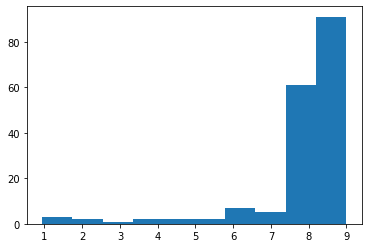

In [13]:
dfA = loadset('set_a.csv')

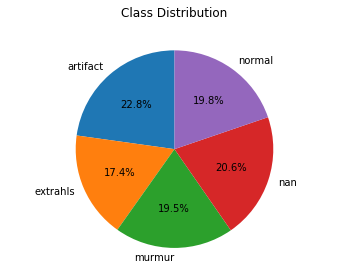

In [14]:
dfA.label = dfA.label.astype(str)
classes = list(np.unique(dfA.label))
class_dist = dfA.groupby(['label'])['length'].mean()
distplt(class_dist)

In [0]:
dfA.reset_index(inplace=True)

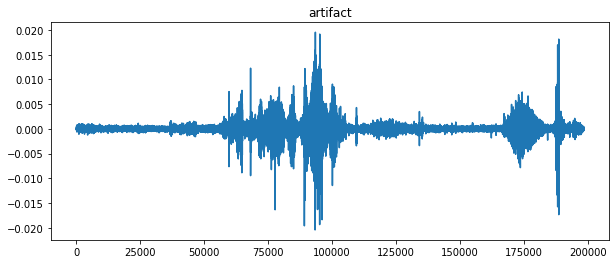

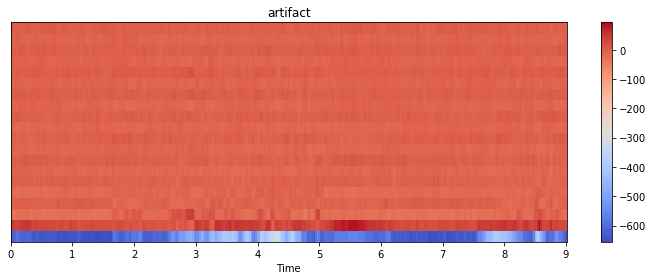

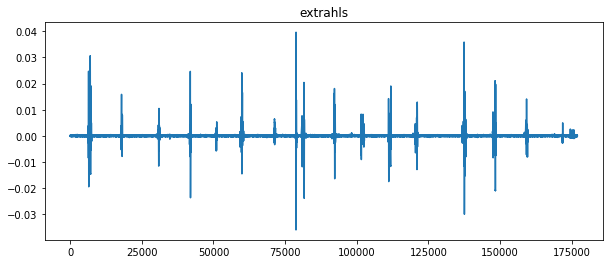

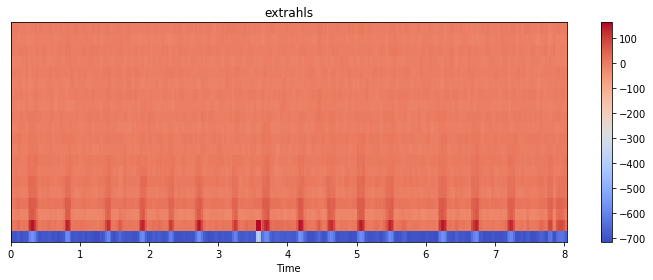

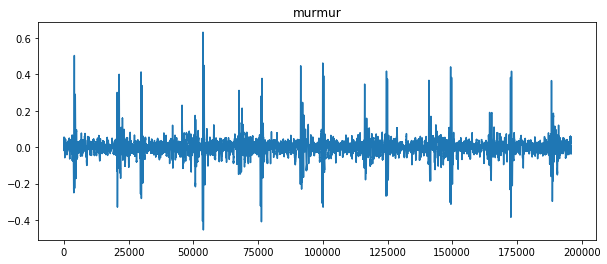

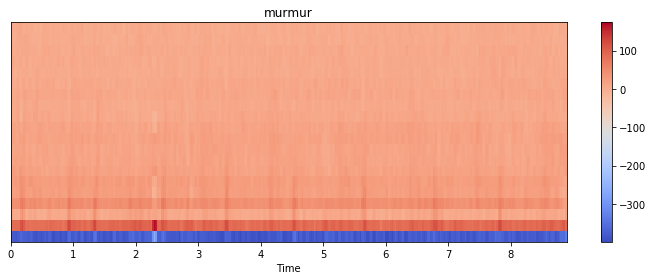

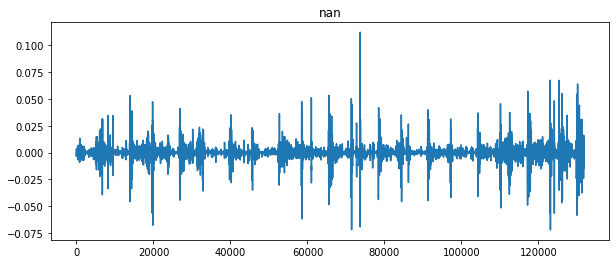

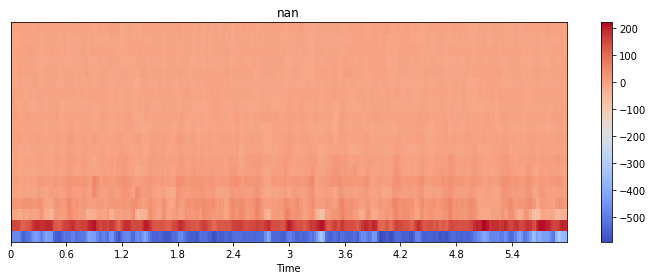

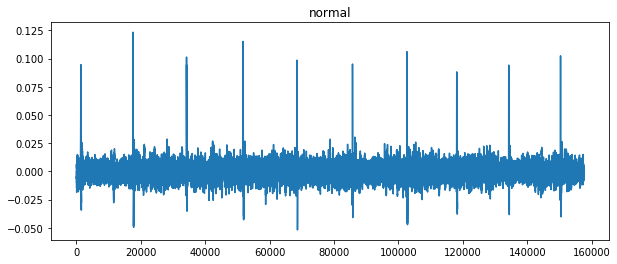

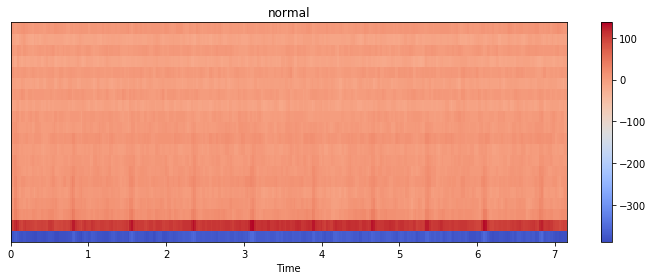

In [16]:
mfccs = {}
for c in classes:
    wav_file = dfA[dfA.label==c].fname.iloc[2]
    wav_file = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',wav_file)
    signal, rate = librosa.load(wav_file, sr=22050)
    plt.figure(figsize=(10, 4))
    plt.title(c)
    plt.plot(signal)
    mfcc = librosa.feature.mfcc(signal, rate)
    mfccs[c] = mfcc
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(c)
    plt.tight_layout()
    plt.show()

NOTE: Sound files do not load in loops so I just ran one as an example.

In [17]:
wav_file = dfA[dfA.label=='murmur'].fname.iloc[0]
print(wav_file)
ipd.Audio(wav_file)

set_a/murmur__201101051104.wav


##Model Creation

###Class and Functions

In [0]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13,nfft=2048,rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [0]:
def build_rand_feat():
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index)
        file = np.random.choice(df[df.label==rand_class].index)
        file = re.sub(r'set_a\/__',r'set_a/Aunlabelledtest__',file)
        rate, wav = wavfile.read(file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = psfmfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode =='time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = tf.keras.utils.to_categorical(y, num_classes = len(classes))

    return X, y

In [0]:
def get_conv_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
                            padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1),
                            padding='same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [0]:
def get_rnn_model():
    model = models.Sequential()
    model.add(layers.LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.TimeDistributed(layers.Dense(64, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(16, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(8, activation='relu')))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(classes), activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

###Main

In [0]:
%%capture
df = loadset('set_a.csv')
df.label = df.label.astype(str)
df = df[~df.label.str.contains("nan")]
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [0]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [0]:
config = Config()

In [0]:
config.mode='time'

In [34]:
X, y = build_rand_feat()

100%|██████████| 19874/19874 [01:08<00:00, 291.12it/s]


In [35]:
y_flat = np.argmax(y, axis=1)
if config.mode == 'conv':
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
elif config.mode == 'time':
    input_shape = (X.shape[1], X.shape[2])
    model = get_rnn_model()
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 128)            72704     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 3, 64)             8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 3, 32)             2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 3, 16)             528       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 3, 8)             

In [0]:
class_weight = compute_class_weight('balanced',
                                     np.unique(y_flat),
                                     y_flat)

In [37]:
model.fit(X, y, epochs=25, batch_size=32,
          shuffle=True,
          class_weight=class_weight)

Train on 19874 samples
Epoch 1/25
19874/19874 [==============================] - 6s 278us/sample - loss: 1.1132 - acc: 0.4688
Epoch 2/25
19874/19874 [==============================] - 4s 180us/sample - loss: 0.8625 - acc: 0.6495
Epoch 3/25
19874/19874 [==============================] - 4s 179us/sample - loss: 0.7744 - acc: 0.6892
Epoch 4/25
19874/19874 [==============================] - 4s 179us/sample - loss: 0.7193 - acc: 0.7122
Epoch 5/25
19874/19874 [==============================] - 4s 187us/sample - loss: 0.6891 - acc: 0.7220
Epoch 6/25
19874/19874 [==============================] - 4s 182us/sample - loss: 0.6771 - acc: 0.7263
Epoch 7/25
19874/19874 [==============================] - 4s 178us/sample - loss: 0.6623 - acc: 0.7305
Epoch 8/25
19874/19874 [==============================] - 4s 193us/sample - loss: 0.6509 - acc: 0.7347
Epoch 9/25
19874/19874 [==============================] - 4s 190us/sample - loss: 0.6421 - acc: 0.7340
Epoch 10/25
19874/19874 [=========================